In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('Consumer_Complaints.csv')
df = df[['Consumer complaint narrative','Product']]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.rename(columns = {'Consumer complaint narrative':'narrative'}, inplace = True)
df.head(10)

,narrative,Product
1,When my loan was switched over to Navient i wa...,Student loan
2,I tried to sign up for a spending monitoring p...,Credit card or prepaid card
7,"My mortgage is with BB & T Bank, recently I ha...",Mortgage
14,The entire lending experience with Citizens Ba...,Mortgage
15,My credit score has gone down XXXX points in t...,Credit reporting
17,I few months back I contacted XXXX in regards...,"Credit reporting, credit repair services, or o..."
28,I '' m a victim of fraud and I have a file wit...,"Credit reporting, credit repair services, or o..."
30,"My mortgage is owned by XXXX, we have painfull...",Mortgage
32,I have been disputing a Bankruptcy on my credi...,"Credit reporting, credit repair services, or o..."
54,Today I received a phone call from a number li...,Debt collection


In [4]:
df.shape

(318718, 2)

In [5]:
df.index = range(318718)

In [6]:
df['narrative'].apply(lambda x: len(x.split(' '))).sum()

63420212

We have over 63 million words, it is not a small data set.

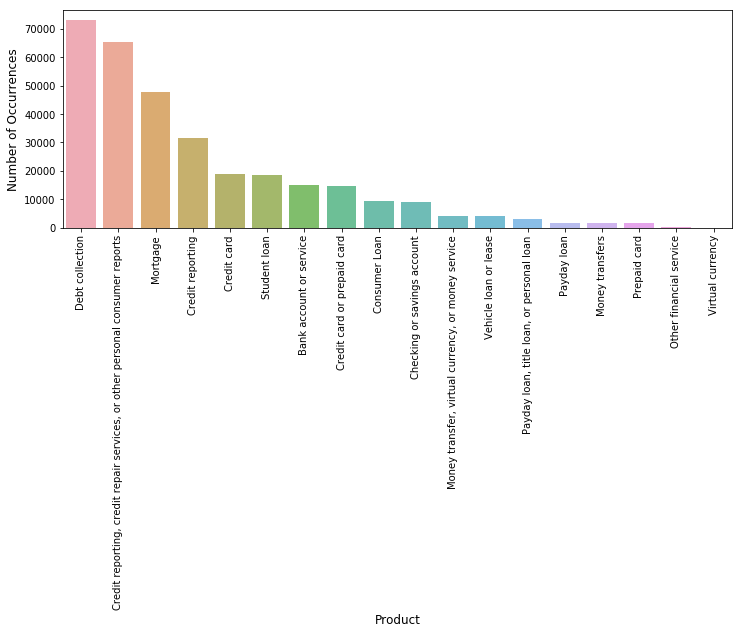

In [7]:
cnt_pro = df['Product'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

The classes are imbalanced. However, a naive classifier that predicts everything to be Debt collection will only achieve over 20% accuracy.

Let's have a look a few examples of complaint narrative and its associated product.

In [8]:
def print_complaint(index):
    example = df[df.index == index][['narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [9]:
print_complaint(12)

I APPARENTLY HAVE AN OUTSTANDING DEBT WITH XXXX XXXX. THEY SENT THE ACCOUNT TO XXXX  XXXX XXXX. THIS COLLECTION COMPANY CALLS MY WORK AND CELL SEVERAL TIMES A DAY. UP TO 6 TIMES A DAY. I TRY TO TELL THE COMPANY TO STOP CALLING ME AND THEY HANG UP LAUGHING. I HAVE NOT RECEIVED ANY PAPERWORK FROM THIS COMPANY. AND XXXX XXXX REFUSE TO SPEAK WITH ME. I HAVE MAILED IN A CEASE AND DESIST, AND I HAVE CALLED THEM TO GET THEIR FAX NUMBER TO SEND IN THE PAPERWORK-THEY KEEP GIVING ME DIFFERENT ONES ( FAX # XXXX ) I DON'T OWE ANY MONEY TO XXXX, I CLOSED THE ACCOUNT WITH A XXXX BALANCE AND TURNED IN ALL OF MY EQUIPMENT THAT I WAS RENTING. AND SO DID MY WIFE.
Product: Debt collection


In [10]:
print_complaint(20)

In late XXXX of 2017 I requested a balance transfer from my Comenity Bank Visa card to pay off a high balance on another credit card I have. On XXXX XXXX, 2017 the charge posted to my Comenity Bank Visa card account however, as of today ( XXXX XXXX, 2017 ) they have never sent the money to pay off the other credit card. I have tried to resolve the problem with several phone calls to Comenity Bank but no one has been able to give a reasonable explanation of why they are charging my credit card account without actually sending the money to pay off the other credit card. I have also sent them a written dispute of the charge but have received no response yet.
Product: Credit card or prepaid card


### Text preprocessing

Below we define a function to convert text to lower-case and strip punctuation/symbols from words and so on.

In [11]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['narrative'] = df['narrative'].apply(cleanText)

In [12]:
df['narrative'][20]

'in late  of 2017 i requested a balance transfer from my comenity bank visa card to pay off a high balance on another credit card i have. on  , 2017 the charge posted to my comenity bank visa card account however, as of today (  , 2017 ) they have never sent the money to pay off the other credit card. i have tried to resolve the problem with several phone calls to comenity bank but no one has been able to give a reasonable eplanation of why they are charging my credit card account without actually sending the money to pay off the other credit card. i have also sent them a written dispute of the charge but have received no response yet.'

Train/test split of 70/30.

In [13]:
train, test = train_test_split(df, test_size=0.3, random_state=42)

In [14]:
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [15]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)

This is what a training entry looks like - an example complaint narrative tagged by 'Credit reporting'.

In [16]:
train_tagged.values[30]

TaggedDocument(words=['had', 'bankruptcy', 'years', 'ago', 'and', 'it', 'is', 'still', 'showing', 'up', 'on', 'equifa', 'which', 'is', 'preventing', 'me', 'from', 'buying', 'home', 'at', 'good', 'rate', 'they', 'need', 'to', 'take', 'it', 'off', 'like', 'did', 'so', 'my', 'score', 'will', 'be'], tags=['Credit reporting'])

## Training the model

We'll instantiate a Doc2Vec model-Distributed Bag of Words (DBOW). In the Word2Vec architecture, the two algorithm names are “continuous bag of words” (cbow) and “skip-gram” (sg); in the Doc2Vec architecture, the corresponding algorithms are “distributed bag of words” (dbow) and “distributed memory” (dm).

### DBOW

DBOW is the Doc2Vec model analogous to Skip-gram model in Word2Vec. The paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

Training a Doc2Vec model is rather straight forward in Gensim, we initialize the model and train for 30 epochs:

We set the minimum word count to 2 in order to discard words with very few occurrences. 

In [17]:
import multiprocessing

cores = multiprocessing.cpu_count()

Build a vocabulary

In [19]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 223102/223102 [00:00<00:00, 2855261.21it/s]


In [20]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 223102/223102 [00:00<00:00, 2033057.94it/s]


Wall time: 18min 24s


### Buliding the final vector feature for the classifier.

In [21]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [22]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [23]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [24]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.6683609437751004
Testing F1 score: 0.651646431211616


### Distributed Memory with Averaging

Distributed Memory (DM) acts as a memory that remembers what is missing from the current context — or as the topic of the paragraph. While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document.
We again instantiate a Doc2Vec model with a vector size with 300 words and iterating over the training corpus 30 times.

In [35]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 223102/223102 [00:00<00:00, 1886113.74it/s]


In [36]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 223102/223102 [00:00<00:00, 2778023.03it/s]


Wall time: 33min 28s


### Train Logistic Regression

In [37]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.47498326639892907
Testing F1 score: 0.4445833078167434


In [42]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [46]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [48]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [49]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)

In [50]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.6778572623828648
Testing F1 score: 0.664561533967402
